# Tuning Hyperparameters using Bayesian Search

The Bayesian Search package from https://github.com/fmfn/BayesianOptimization was used. In examples https://github.com/fmfn/BayesianOptimization/tree/master/examples there is a lot of guidance on how to set up the search.

# Step 1: Importing all required functions and importing the data. 

In [111]:
import handle_data

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from bayes_opt import BayesianOptimization, UtilityFunction, SequentialDomainReductionTransformer
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events


from sklearn.linear_model import LinearRegression

from yellowbrick.regressor import ResidualsPlot

In [130]:
variable_to_predict = "TotalExpenditure"

In [58]:
def import_data(desired_features = None):
    # Import the data
    data = handle_data.csv_to_dataframe("logfiles.csv")
    data = handle_data.strategies(data, "check_in_strategies.csv", "security_strategies.csv", include_checkin=True, include_security=True, replace=True)
    
    # Remove outliers from training and val
    #data = handle_data.remove_faulty(data, variable_to_predict, 1.5, ["INI", "ADA", "HO"])
    
    training, val, test = handle_data.split_data(data)
    
    training = handle_data.manipulate_data(training)
    val = handle_data.manipulate_data(val)
    test = handle_data.manipulate_data(test)
    
    if desired_features != None:
        training["Input"] = training["Input"][desired_features]
        val["Input"] = val["Input"][desired_features]
        test["Input"] = test["Input"][desired_features]
    
    # Remove outliers
    
    return training, val, test

In [59]:
# desired_features = ["CallToGateStrategy", "S1800-3600", "NumberPaxFlight7"]
desired_features = None
training, val, test = import_data(desired_features)
print(training["Input"].shape)

[DEBUG] Reading logfiles.csv into dataframe
[DEBUG] Finished reading logfiles.csv into dataframe after 0.5361974239349365 seconds
(76635, 18)


# Step 2: Setting up the objective function and search algorithm.

In rf_model the objective function to maximise is setup. Note the error is multiplied by -1 as the function is maximised but the error has to be minimised.

For integer hyperparameter, the number is rounded to an integer.

In tune_hyperparameters_bayes the searching grid is set up, as well as the bayes searching algorithm. The results of the Bayes search are automatically logged into the "bayes_logs" folder, so it can be re-used later if further searching is required.

In [74]:
def rf_model(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    params_rf = {}
    params_rf['n_estimators'] = round(n_estimators)
    params_rf['max_depth'] = round(max_depth)
    params_rf['min_samples_split'] = round(min_samples_split)
    params_rf['min_samples_leaf'] = round(min_samples_leaf)
    
    params_rf['max_features'] = 10
    params_rf['criterion'] = 'squared_error'
    params_rf['n_jobs'] = 12
    params_rf['bootstrap'] = True
    
    model = RandomForestRegressor(**params_rf, random_state=0)
    model.fit(training["Input"], training["Output"][variable_to_predict])
    y_pred = model.predict(val["Input"])

    mse = mean_squared_error(val["Output"][variable_to_predict], y_pred)
    mae = mean_absolute_error(val["Output"][variable_to_predict], y_pred)
    ratio = np.sqrt(mse) / mae
    return -1 * np.sqrt(mse)

In [75]:
bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0)

In [106]:
def tune_hyperparamaters_bayes(kappa):
    params = dict()
    params['n_estimators'] = (1,1000)
    params['max_depth'] = (1, 500)
    params['min_samples_split'] = (2, 1000)
    params['min_samples_leaf'] = (1, 2000)
    # params['max_features'] = (1, 18)
    
    # Create the hyperparameter tuning program
    # rf_tuning = BayesianOptimization(rf_model, params, random_state=0, bounds_transformer = bounds_transformer)
    rf_tuning = BayesianOptimization(rf_model, params, random_state=0)
    # Fit the random search model
    
    acquisition_function = UtilityFunction(kind="ucb", kappa=kappa)
    
    logger = JSONLogger(path="./bayes_logs\\logs.json")
    rf_tuning.subscribe(Events.OPTIMIZATION_STEP, logger)
    rf_tuning.set_gp_params()
    
    return rf_tuning, acquisition_function    

# Step 3: Peforming the search

Init_points are the first m points that are randomly sampled from the search grid to get a starting surrogate model. n_iter are the next n points that are picked by the acquisition function.

In [131]:
tuning, acquisition_function = tune_hyperparamaters_bayes(0.1)

tuning.maximize(init_points=100, n_iter=100, acquisition_function = acquisition_function)

KeyboardInterrupt: 

# Step 4: Taking notes of the optimal parameters

In [112]:
tuning.max

{'target': -132.42509131644783,
 'params': {'max_depth': 165.468191593492,
  'min_samples_leaf': 58.8678862500497,
  'min_samples_split': 812.2269948032765,
  'n_estimators': 259.6273211232252}}

In [125]:
# Expenditure

# Lowest error so far:
# Alpha = standard, Kappa = 0.1 (Exploitation focus)
# 100 random iterations, 1000 bayes iterations
# Runtime ~ 1 hour
# error: 131.96599110961716

# Parameters that where fixed: 
#     params_rf['max_features'] = 10
#     params_rf['criterion'] = 'squared_error'
#     params_rf['n_jobs'] = 12 (CPU Threads, using 12/16)
#     params_rf['bootstrap'] = True



params1 =\
{
    'max_depth': 296,
    'min_samples_leaf': 155,
    'min_samples_split': 246,
    'n_estimators': 281,
    
    'n_jobs':  12,
    'criterion': 'squared_error',
    'max_features': 10,
    'bootstrap': True
}


# Other run but I did not normalise y: (same settings)
# error: 132.42509131644783

params2 =\
{
    'max_depth': 165,
    'min_samples_leaf': 59,
    'min_samples_split': 812,
    'n_estimators': 260,
    
    'criterion': 'squared_error',
    'max_features': 10,
    'bootstrap': True
}


# Step 5: Analyzing the performance of the model

First we train the model with the desired set of hyperparameters. Next a basic linear regressor is trained to compare it against. Finally residual plots and QQ plots and histograms are constructed to study the residual behaviour.

In [126]:
def train(params):
    model = RandomForestRegressor(**params, random_state=0)
    model.fit(training["Input"], training["Output"]["TotalExpenditure"])
    
    # Validation set
    y_pred_val = model.predict(val["Input"])
    mse = mean_squared_error(val["Output"]["TotalExpenditure"], y_pred_val)
    mae = mean_absolute_error(val["Output"]["TotalExpenditure"], y_pred_val)
    ratio = np.sqrt(mse) / mae
    
    print(f"Trained model\nvalidation: rmse: {np.sqrt(mse)}, mae: {mae}, ratio: {ratio}")
    
    # Test set
    y_pred_test = model.predict(test["Input"])
    mse = mean_squared_error(test["Output"]["TotalExpenditure"], y_pred_test)
    mae = mean_absolute_error(test["Output"]["TotalExpenditure"], y_pred_test)
    ratio = np.sqrt(mse) / mae
    
    print(f"Test set: rmse: {np.sqrt(mse)}, mae: {mae}, ratio: {ratio}" )
    
    return model

In [127]:
model = train(params1)
model = train(params2)

Trained model
validation: rmse: 133.59947921936092, mae: 104.83768097511533, ratio: 1.2743459982777814
Test set: rmse: 134.57771132433066, mae: 106.15774471369389, ratio: 1.2677144911780585
Trained model
validation: rmse: 132.42509131644783, mae: 104.04588474199502, ratio: 1.2727566462126338
Test set: rmse: 133.72793247893523, mae: 105.5042797279995, ratio: 1.2675119229636855


In [92]:
linearmodel = LinearRegression()
linearmodel.fit(training["Input"], training["Output"][variable_to_predict])
y_pred = linearmodel.predict(test["Input"])

rmse = np.sqrt(mean_squared_error(test["Output"][variable_to_predict], y_pred))
mae = mean_absolute_error(test["Output"][variable_to_predict], y_pred)
ratio = rmse / mae

print(f"Linear model test set: rmse: {rmse}, mae: {mae}, ratio: {ratio}" )

Linear model test set: rmse: 142.33358445334852, mae: 113.15974898029505, ratio: 1.2578110656478536


C:\Users\hugob\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



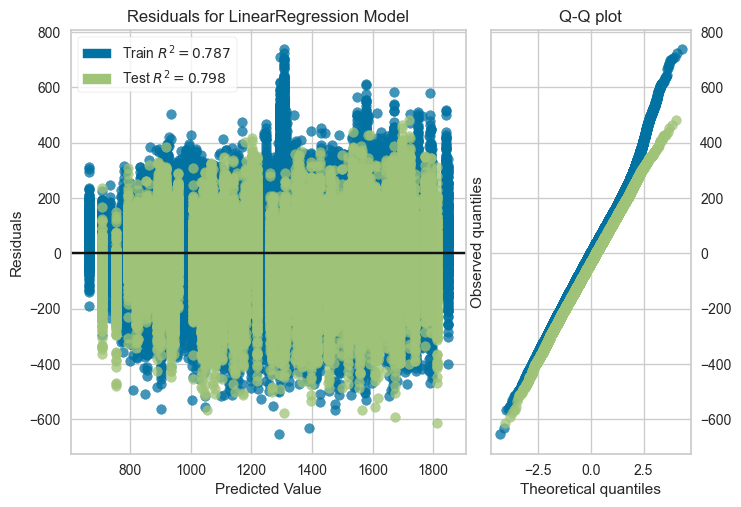

C:\Users\hugob\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



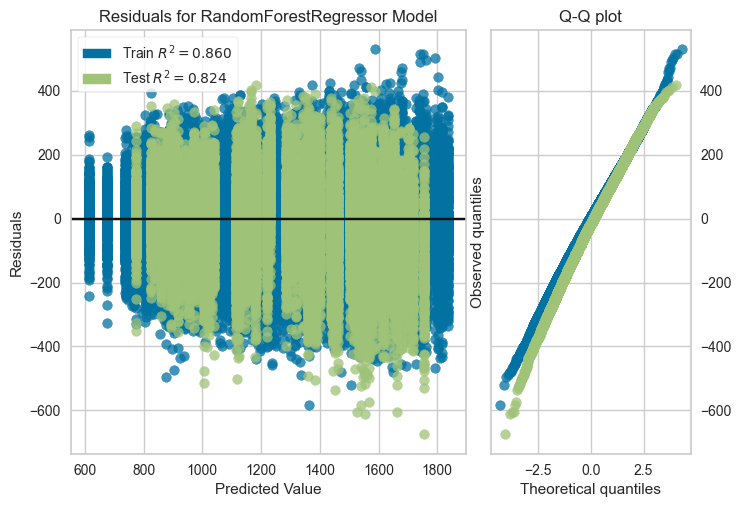

C:\Users\hugob\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



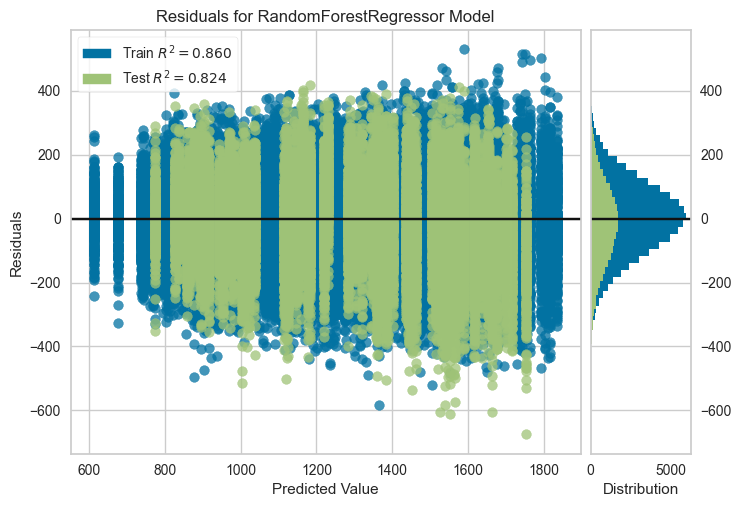

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [94]:
visualizer = ResidualsPlot(linearmodel, hist=False, qqplot = True)

visualizer.fit(training["Input"], training["Output"][variable_to_predict])  # Fit the training data to the visualizer
visualizer.score(test["Input"], test["Output"][variable_to_predict])  # Evaluate the model on the test data
visualizer.show()    

visualizer = ResidualsPlot(model, hist=False, qqplot = True)

visualizer.fit(training["Input"], training["Output"][variable_to_predict])  # Fit the training data to the visualizer
visualizer.score(test["Input"], test["Output"][variable_to_predict])  # Evaluate the model on the test data
visualizer.show()     

visualizer = ResidualsPlot(model, hist=True, qqplot = False)

visualizer.fit(training["Input"], training["Output"][variable_to_predict])  # Fit the training data to the visualizer
visualizer.score(test["Input"], test["Output"][variable_to_predict])  # Evaluate the model on the test data
visualizer.show()     